# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [11]:

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.
THIS Cutter Insect Repellent with Picaridin is safer and less strong odor that DEET products.  It was not on retail stores this Summer (2011)in my area of the country.  Amazon was the only place where I could find it.  If you are faced with a dense mosquito population, pour in on legs on knees & below allowing it to run into socks.  Just spraying it will often not give full saturation and bugs have a way of finding that bare spot.  DEET products are available everywhere and may last longer, but read the warnings about the risk of long term or heavy dose of  DEET.


In [16]:

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [17]:

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.
THIS Cutter Insect Repellent with Picaridin is safer and less strong odor that DEET products.  It was not on retail stores this Summer (2011)in my area of the country.  Amazon was the only place where I could find it.  If you are faced with a dense mosquito population, pour in on legs on knees & below allowing it to run into socks.  Just spraying it will often not give full saturation and bugs have a way of finding that bare spot.  DEET products are available everywhere and may last longer, but read the warnings about the risk of long term or heavy dose of  DEET.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Sprout seed mix arrived very promptly and in great condition I needed them for our local farmers market and will be ordering more very soon 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 62862/62862 [00:20<00:00, 3070.49it/s]


In [24]:
preprocessed_reviews[62000]

'really like maple syrup try get grade b darker color stronger flavor grade also pretty darn good big jug oz last transfer smaller containers heat use table probably not better deal get grocery shipping good value live far away larger town combine maple fix orders defray avoid shipping charges'

## [4] Featurization

#### [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

#### [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

#### [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

#### [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

#### [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 5: Apply Logistic Regression

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>


###### Taking 100k sample dataset points from the given data

In [25]:
#obtaining the cleaned_text from the preprocessed_reviews  for the given dataset.
final['cleaned_text']=preprocessed_reviews
#Applying the time based splitting for the sample 15k datapts.
final.sort_values(by='Time')
final1 = final.sample(n = 50000)

Y = final1['Score'].values
X = final1['cleaned_text'].values
print(X.shape,type(X))
print(Y.shape,type(Y))

(50000,) <class 'numpy.ndarray'>
(50000,) <class 'numpy.ndarray'>


In [0]:
#importing library.
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [27]:
# performing training,CV & testing for performing splitting of the dataset.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
print("*"*10)
print("After splitting the data")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

**********
After splitting the data
(40000,) (40000,)
(10000,) (10000,)
(10000,) (10000,)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)

X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)

print("After transforming the data")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transforming the data
(40000, 37713) (40000,)
(10000, 37713) (10000,)
(10000, 37713) (10000,)


In [30]:
#Performimng hyper parameter tuning using GridSearchCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}]
model = GridSearchCV(LogisticRegression(penalty ='l1'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_bow,Y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [31]:
#obtaining the best_estimator parameter from the given model.
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


100%|██████████| 8/8 [00:05<00:00,  1.01s/it]


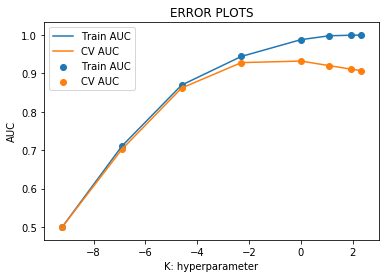

In [32]:
#Performing roc_auc metric  for train & cv.
import math
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C = i,penalty='l1')
    logit.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

100%|██████████| 50/50 [03:42<00:00,  5.77s/it]

******************************************************************************************************************************************************
optimal no of neighbors: 0.33


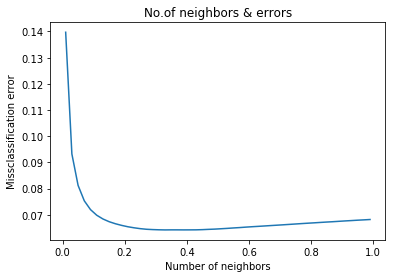

In [33]:
#perfrorming cross_validation for the given data


C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l1')
    score = cross_val_score(logit1,X_train_bow,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l1 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l1,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
optimal_model = LogisticRegression(C= optimal_l1,penalty='l1')
optimal_model.fit(X_train_bow,Y_train)
prediction = optimal_model.predict(X_test_bow)

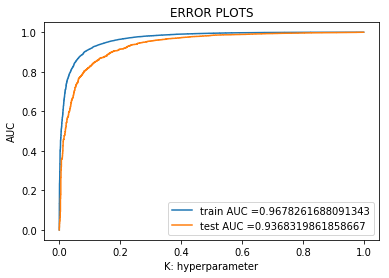

In [36]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [37]:
training_accuracy = optimal_model.score(X_train_bow,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.9356
training error 0.06440000000000001
testing acuracy 0.9129
testing error 0.08709999999999996


confusion_matrix for train_data


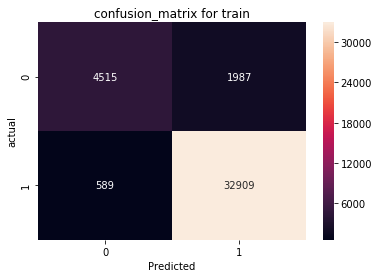

********************
confusion_matrix for test_data.


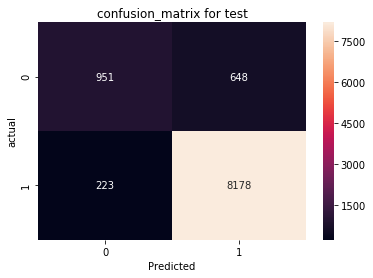

In [38]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.81      0.59      0.69      1599
           1       0.93      0.97      0.95      8401

    accuracy                           0.91     10000
   macro avg       0.87      0.78      0.82     10000
weighted avg       0.91      0.91      0.91     10000



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
######  Calculating weight vectors form the variable "C"

In [41]:
clf = LogisticRegression(C=0.0001,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

0


In [42]:
clf = LogisticRegression(C=0.001,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

3


In [43]:
clf = LogisticRegression(C=0.01,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

92


In [44]:
clf = LogisticRegression(C=0.1,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

669


In [45]:
clf = LogisticRegression(C=1,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

3501


In [46]:
clf = LogisticRegression(C=10,penalty='l1')
clf.fit(X_train_bow,Y_train)
weight = clf.coef_
print(np.count_nonzero(weight))

6484


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [47]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}] 
model = GridSearchCV(LogisticRegression(penalty ='l2'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_bow,Y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

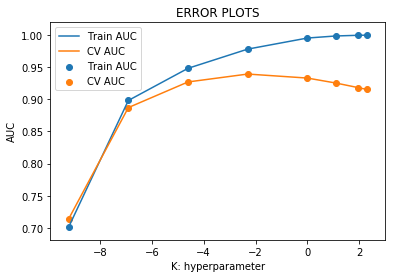

In [48]:
import math
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2') 
    logit.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


******************************************************************************************************************************************************
optimal no of neighbors: 0.11


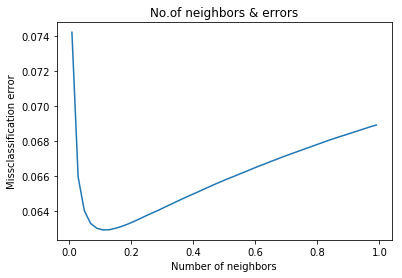

In [49]:
C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l2')
    score = cross_val_score(logit1,X_train_bow,Y_train,cv=5,scoring='roc_auc')
    cv_score.append(score.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l2 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l2,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l2,penalty='l2')
optimal_model.fit(X_train_bow,Y_train)
prediction = optimal_model.predict(X_test_bow)

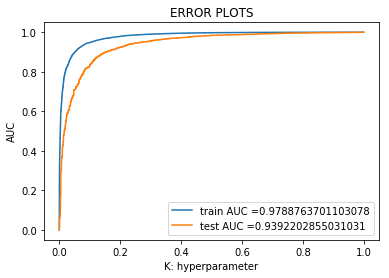

In [51]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [52]:
training_accuracy = optimal_model.score(X_train_bow,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.9457
training error 0.054300000000000015
testing acuracy 0.9121
testing error 0.08789999999999998


confusion_matrix for train_data


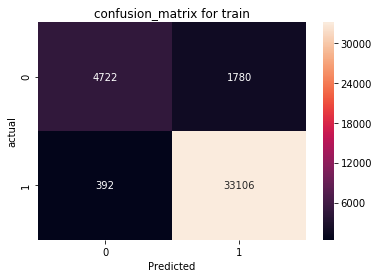

********************
confusion_matrix for test_data.


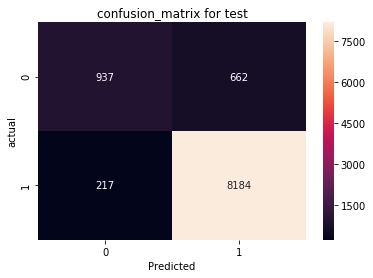

In [53]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_bow))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1599
           1       0.93      0.97      0.95      8401

    accuracy                           0.91     10000
   macro avg       0.87      0.78      0.81     10000
weighted avg       0.91      0.91      0.91     10000











#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [55]:
clf = LogisticRegression(C = optimal_l2,penalty='l2')
clf.fit(X_train_bow,Y_train)
w = clf.coef_
print(w.shape)
print(X_train_bow.shape)
#####################################################################################
error = 2
X_train_bow.data +=(error)
print(X_train_bow.shape)

(1, 37713)
(40000, 37713)
(40000, 37713)


In [56]:
clf = LogisticRegression(C=optimal_l2, penalty='l2');
clf.fit(X_train_bow, Y_train);
w1 = clf.coef_
print(type(w1),w1.shape)

<class 'numpy.ndarray'> (1, 37713)


In [57]:
w = w+10**-6
w1 = w1+10**-6
change = abs((w-w1)/w)*100
print(change.shape)

(1, 37713)


In [58]:
print(change.shape)
feature_names=vectorizer.get_feature_names()

print(feature_names[:5])

(1, 37713)
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa']


In [0]:
from matplotlib import mlab

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: numpy.percentile
  


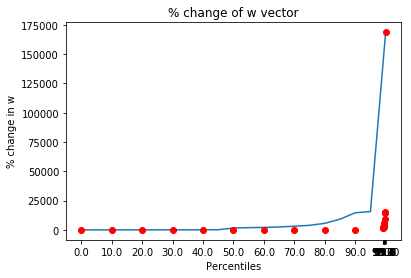

In [60]:
p = np.array([0,10,20,30,40,50,60,70,80,90,99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100])
percentile = mlab.prctile(change,p)
plt.plot(percentile)

plt.plot  ((len(percentile)-1)*p/100,percentile, 'ro')
plt.xticks((len(percentile)-1)*p/100,map(str,p))

plt.xlabel("Percentiles")
plt.ylabel("% change in w")
plt.title("% change of w vector")
plt.show()

In [61]:
change_features = pd.DataFrame(change,columns = feature_names)
change_features = change_features.T

change_features.columns = ['change1']
print('99.9th percentile')
change_features.change1.quantile(0.99)

99.9th percentile


1656.3943753970505

In [62]:
collinear_features = change_features[change_features. change1 > int(change_features.change1.quantile(0.999))]
collinear_features=list(collinear_features.T.columns.values)
print(collinear_features)

['altered', 'bcuz', 'booster', 'carmelized', 'carotene', 'cheers', 'coffee', 'conversely', 'deceased', 'desiring', 'dredge', 'gluey', 'holder', 'jabchae', 'jigae', 'kashi', 'leavening', 'machines', 'master', 'mighty', 'mistaken', 'misunderstand', 'obligatory', 'olsen', 'peak', 'pebbly', 'phosphate', 'pinches', 'produced', 'receiving', 'replenishment', 'scraping', 'suppository', 'toffees', 'tote', 'upcoming', 'upset', 'vehicle']


In [63]:
w = optimal_model.coef_
feature_names=vectorizer.get_feature_names()

print(feature_names[:5])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [64]:
w=optimal_model.coef_
feature_names=vectorizer.get_feature_names()
print(feature_names[:5])
features1=pd.DataFrame(w,columns=([feature_names]))

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa']


In [0]:
features1=features1.T
features1.columns=['w']

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [66]:
features1=features1.sort_values(by=['w'],ascending=False)
print(features1.head(10))

                  w
delicious  1.464969
perfect    1.392985
excellent  1.318827
wonderful  1.281395
best       1.172745
amazing    1.162149
awesome    1.154907
loves      1.128254
yummy      1.113605
great      1.094719


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [67]:
# Important features for negative class.
features1=features1.sort_values(by=['w'],ascending= True)
print(features1.head(10))

                      w
disappointing -1.670695
worst         -1.633290
awful         -1.525020
terrible      -1.399401
horrible      -1.305585
disappointed  -1.250944
unfortunately -1.114424
threw         -1.094308
sorry         -1.079984
waste         -1.057141


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
Tfidf_vect.fit(X_train)

X_train_tfidf= Tfidf_vect.transform(X_train)
X_cv_tfidf=Tfidf_vect.transform(X_cv)
X_test_tfidf=Tfidf_vect.transform(X_test)

In [69]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}]
model = GridSearchCV(LogisticRegression(penalty ='l1'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_tfidf,Y_train)
#########################################

#obtaining the best_estimator parameter from the given model.
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


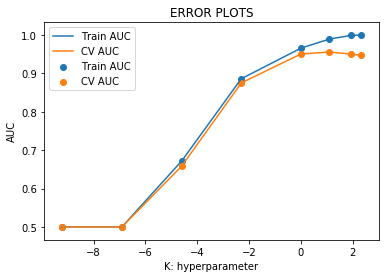

In [70]:
import math
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l1')
    logit.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


******************************************************************************************************************************************************
optimal no of neighbors: 0.99


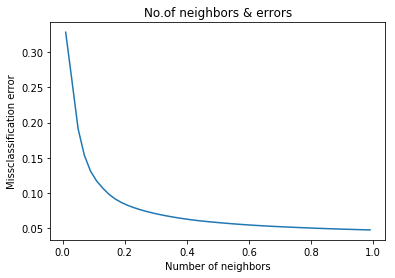

In [71]:

C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l1')
    score = cross_val_score(logit1,X_train_tfidf,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l3 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l3,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l3,penalty='l1')
optimal_model.fit(X_train_tfidf,Y_train)
prediction = optimal_model.predict(X_test_tfidf)

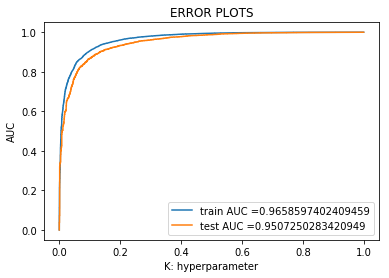

In [73]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [74]:
training_accuracy = optimal_model.score(X_train_tfidf,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.933525
training error 0.06647499999999995
testing acuracy 0.9175
testing error 0.08250000000000002


confusion_matrix for train_data


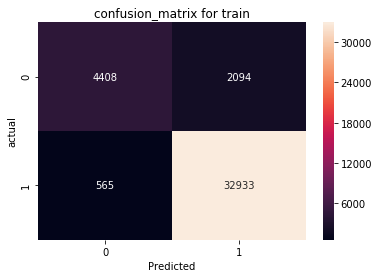

********************
confusion_matrix for test_data.


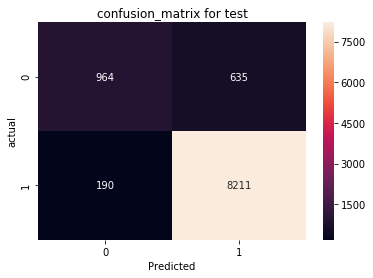

In [75]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_tfidf))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_tfidf))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [76]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1599
           1       0.93      0.98      0.95      8401

    accuracy                           0.92     10000
   macro avg       0.88      0.79      0.83     10000
weighted avg       0.91      0.92      0.91     10000



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [77]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}]
model = GridSearchCV(LogisticRegression(penalty ='l2'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_tfidf,Y_train)

#obtaining the best_estimator parameter from the given model.
print(model.best_estimator_)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


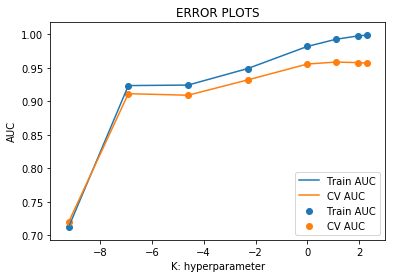

In [78]:
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2')
    logit.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


optimal no of neighbors: 0.99


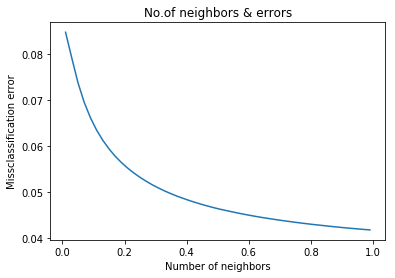

In [79]:
C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l2')
    score = cross_val_score(logit1,X_train_tfidf,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())
###########################################################################################
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l4 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l4,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l4,penalty='l2')
optimal_model.fit(X_train_tfidf,Y_train)
prediction = optimal_model.predict(X_test_tfidf)

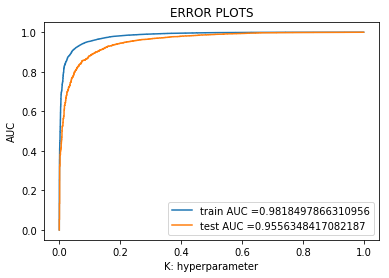

In [81]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC4=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")

plt.title("ERROR PLOTS")
plt.show()

In [82]:
training_accuracy = optimal_model.score(X_train_tfidf,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.939725
training error 0.06027499999999997
testing acuracy 0.9126
testing error 0.08740000000000003


confusion_matrix for train_data


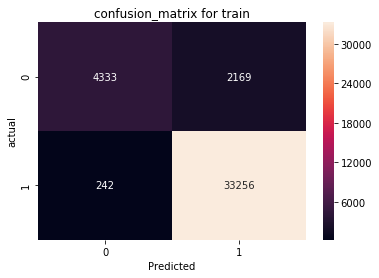

********************
confusion_matrix for test_data.


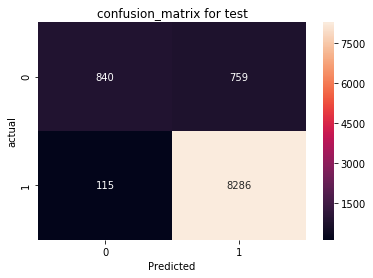

In [83]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(X_train_tfidf))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(X_test_tfidf))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [84]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.88      0.53      0.66      1599
           1       0.92      0.99      0.95      8401

    accuracy                           0.91     10000
   macro avg       0.90      0.76      0.80     10000
weighted avg       0.91      0.91      0.90     10000



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [85]:

w=optimal_model.coef_
feature_names=Tfidf_vect.get_feature_names()
print(feature_names[:5])
features1=pd.DataFrame(w,columns=([feature_names]))

['aa', 'ability', 'able', 'able buy', 'able chew']


In [86]:
#Top 10 important features
features1= features1.T
features1.columns=['w']

features1=features1.sort_values(by=['w'],ascending=False)
print(features1.head(10))

                  w
great      9.304548
best       7.201629
delicious  6.991051
good       6.275096
love       5.953220
perfect    5.700333
loves      5.394906
nice       5.143368
wonderful  5.007516
excellent  4.950650


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [87]:
features1=features1.sort_values(by=['w'],ascending= True)
print(features1.head(10))

                      w
not           -7.188446
disappointed  -6.864138
worst         -5.653421
awful         -5.544129
terrible      -5.281222
disappointing -5.246645
horrible      -5.149730
not good      -4.964502
not worth     -4.725700
bad           -4.639403


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [88]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12199
sample words  ['dog', 'loves', 'nylabone', 'dental', 'chews', 'love', 'breath', 'smells', 'good', 'devours', 'one', 'tasting', 'cinnamon', 'high', 'quality', 'product', 'well', 'packaged', 'leak', 'proof', 'foil', 'lined', 'bags', 'finely', 'ground', 'sprinkles', 'easily', 'definitely', 'order', 'reviews', 'tins', 'arrived', 'wafers', 'crushed', 'ended', 'using', 'spoon', 'eat', 'crumbs', 'tin', 'opened', 'delicious', 'cannot', 'imagine', 'serving', 'guests', 'chocolate', 'also', 'melted', 'avoid']


In [89]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])


(40000, 50)
[ 0.57426642  0.70209407 -0.82832273  0.09036855 -0.47134656 -0.13486786
 -1.45402508 -0.04748693 -0.29618335  0.13095854  0.05788112 -0.13859307
 -0.13438315 -0.13575891  0.31292725  0.51055014  0.52986218  0.7615251
  0.32994418 -0.41565543 -0.09313771 -0.70181523 -0.06330854  0.54845364
 -0.05026809 -0.18239521 -0.04103103  0.94788393  0.59310178 -0.24284077
  0.81923683  1.21589826  0.03326813 -1.67131962  1.12372318 -0.53347346
 -0.11596013  0.83061213 -0.56013681  0.81355247 -0.31653523 -0.92389298
 -0.14547091  0.40536675 -0.98033451 -0.26384213  0.32124263 -0.17083636
 -0.50724568 -0.21667541]


In [90]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


(10000, 50)
[-0.02885698  0.26411754 -0.61515925 -0.29704633  0.19328106 -0.95991287
 -0.60155868  0.45080369 -0.08030964 -0.14061223 -0.59488764 -0.33386234
  0.22187807  0.1606875   0.26976182 -0.3711843   1.65924559  0.56565492
 -0.96905851  0.21038694 -0.61292139 -0.92705019  0.1220661   0.35405521
  0.87052791  0.40804586  0.05933433 -0.36484512 -0.14652385 -0.2788176
  0.39930466 -0.15367072  0.67886929  0.37004695 -0.2839749  -0.06954547
 -1.3000716   0.34904301  0.06176071  0.21903748  0.07517871  0.56744648
 -0.22868096 -0.84511855  0.28182697  0.67307328 -0.60451704 -0.23107643
 -0.82656747  0.43355977]


In [91]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])


(10000, 50)
[-0.02885698  0.26411754 -0.61515925 -0.29704633  0.19328106 -0.95991287
 -0.60155868  0.45080369 -0.08030964 -0.14061223 -0.59488764 -0.33386234
  0.22187807  0.1606875   0.26976182 -0.3711843   1.65924559  0.56565492
 -0.96905851  0.21038694 -0.61292139 -0.92705019  0.1220661   0.35405521
  0.87052791  0.40804586  0.05933433 -0.36484512 -0.14652385 -0.2788176
  0.39930466 -0.15367072  0.67886929  0.37004695 -0.2839749  -0.06954547
 -1.3000716   0.34904301  0.06176071  0.21903748  0.07517871  0.56744648
 -0.22868096 -0.84511855  0.28182697  0.67307328 -0.60451704 -0.23107643
 -0.82656747  0.43355977]


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [92]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}] 
model = GridSearchCV(LogisticRegression(penalty ='l1'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train,Y_train)
#obtaining the best_estimator parameter from the given model.
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


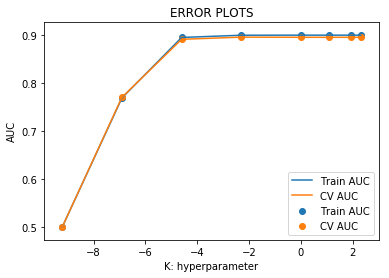

In [93]:
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l1') 
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


optimal no of neighbors: 0.29


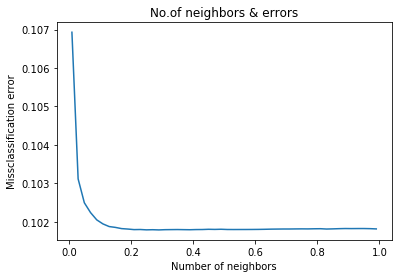

In [94]:
C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l1')
    score = cross_val_score(logit1,sent_vectors_train,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l5 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l5,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l5,penalty='l1')
optimal_model.fit(sent_vectors_train,Y_train)
prediction = optimal_model.predict(sent_vectors_test)

In [96]:
training_accuracy = optimal_model.score(sent_vectors_train,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.8827
training error 0.11729999999999996
testing acuracy 0.8812
testing error 0.11880000000000002


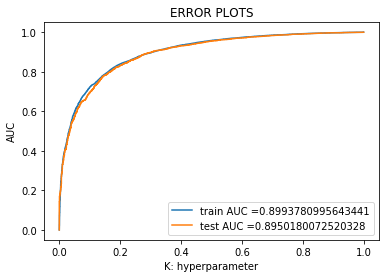

In [97]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


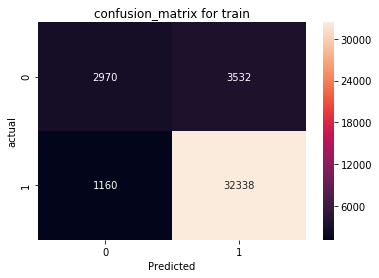

********************
confusion_matrix for test_data.


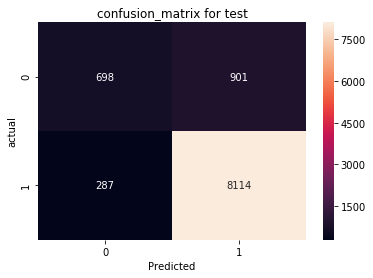

In [98]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [99]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54      1599
           1       0.90      0.97      0.93      8401

    accuracy                           0.88     10000
   macro avg       0.80      0.70      0.74     10000
weighted avg       0.87      0.88      0.87     10000



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [100]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{"C":[10**-2,10**-1,10**0,10**1,10**2]}] 
model = GridSearchCV(LogisticRegression(penalty ='l2'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train,Y_train)
#obtaining the best_estimator parameter from the given model.
print(model.best_estimator_)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


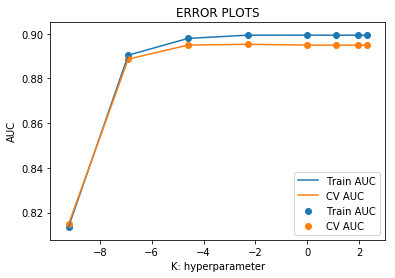

In [101]:
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2') 
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


******************************************************************************************************************************************************
optimal no of neighbors: 0.13


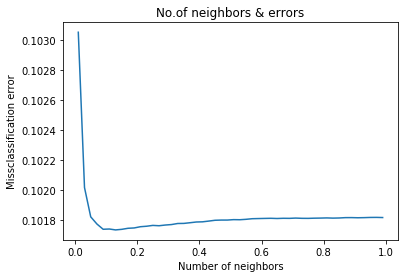

In [102]:


C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l2')
    score = cross_val_score(logit1,sent_vectors_train,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l6 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l6,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l6,penalty='l2')
optimal_model.fit(sent_vectors_train,Y_train)
prediction = optimal_model.predict(sent_vectors_test)

In [104]:
training_accuracy = optimal_model.score(sent_vectors_train,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.882725
training error 0.11727500000000002
testing acuracy 0.8817
testing error 0.11829999999999996


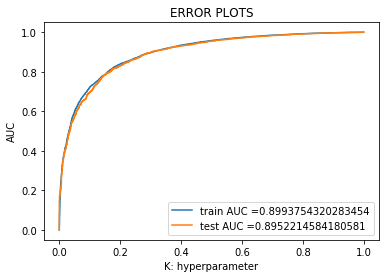

In [105]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


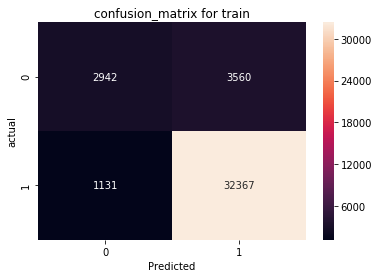

********************
confusion_matrix for test_data.


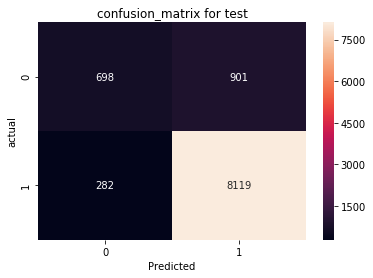

In [106]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [107]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54      1599
           1       0.90      0.97      0.93      8401

    accuracy                           0.88     10000
   macro avg       0.81      0.70      0.74     10000
weighted avg       0.87      0.88      0.87     10000



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:

from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
model = TfidfVectorizer()
Tfidf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [110]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [111]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [112]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = Tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [113]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}] 
model = GridSearchCV(LogisticRegression(penalty ='l1'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=-1)
model.fit(tfidf_sent_vectors_train,Y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

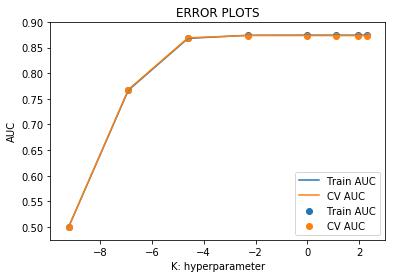

In [114]:
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l1') 
    logit.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


******************************************************************************************************************************************************
optimal no of neighbors: 0.37


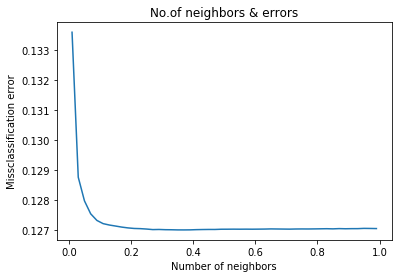

In [118]:

C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l1')
    score = cross_val_score(logit1,tfidf_sent_vectors_train,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

print("*"*150)
# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l7 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l7,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:
optimal_model = LogisticRegression(C= optimal_l7,penalty='l1')
optimal_model.fit(tfidf_sent_vectors_train,Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

In [135]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.871325
training error 0.12867499999999998
testing acuracy 0.8726
testing error 0.12739999999999996


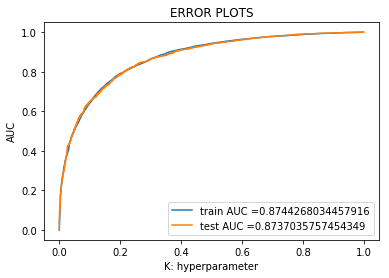

In [136]:

train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC7= str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


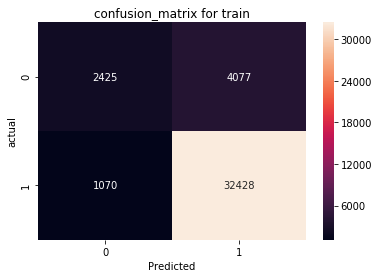

********************
confusion_matrix for test_data.


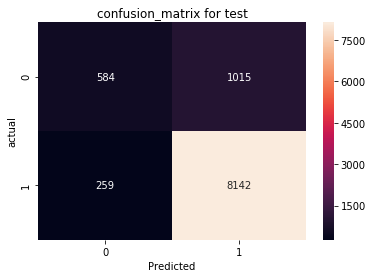

In [123]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(tfidf_sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(tfidf_sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [124]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.37      0.48      1599
           1       0.89      0.97      0.93      8401

    accuracy                           0.87     10000
   macro avg       0.79      0.67      0.70     10000
weighted avg       0.86      0.87      0.86     10000



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [132]:
#Performimng hyper parameter tuning using GridSearchcCV
tuned_parameters = [{'C':[10**-2,10**-1,10**0,10**1,10**2]}] 
model = GridSearchCV(LogisticRegression(penalty ='l2'),tuned_parameters,scoring='roc_auc',cv=10,n_jobs=1)
model.fit(tfidf_sent_vectors_train,Y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=1, param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

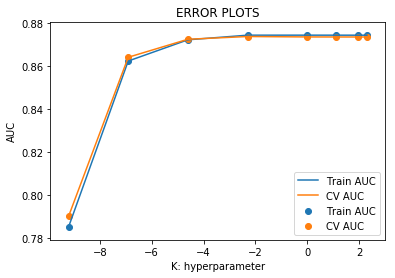

In [133]:
train_auc = []
logc=[]
cv_auc = []

C=[0.0001,0.001,0.01,0.1,1,3,7,10]

for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2') 
    logit.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


optimal no of neighbors: 0.15


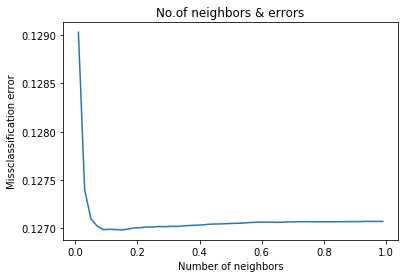

In [137]:

C = list(np.arange(0.01,1,0.02))
cv_score = []
for j in tqdm(C):
    logit1 = LogisticRegression(C= j,penalty ='l2')
    score = cross_val_score(logit1,tfidf_sent_vectors_train,Y_train,cv=10,scoring='roc_auc')
    cv_score.append(score.mean())

# Miss classification error
MSE = [1-x for x in cv_score]
optimal_l8 = C[MSE.index(min(MSE))]
print('optimal no of neighbors:',np.round(optimal_l8,2))

plt.plot(C,MSE)
plt.title('No.of neighbors & errors')
plt.xlabel('Number of neighbors')
plt.ylabel('Missclassification error')
plt.show()

In [0]:

optimal_model = LogisticRegression(C= optimal_l8,penalty='l2')
optimal_model.fit(tfidf_sent_vectors_train,Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

In [141]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train,Y_train)
training_error = 1-training_accuracy

testing_accuracy = accuracy_score(Y_test,prediction)
testing_error = 1- testing_accuracy

print("training_accuracy",training_accuracy)
print("training error",training_error)
print('testing acuracy',testing_accuracy)
print('testing error',testing_error)

training_accuracy 0.87115
training error 0.12885000000000002
testing acuracy 0.8725
testing error 0.12749999999999995


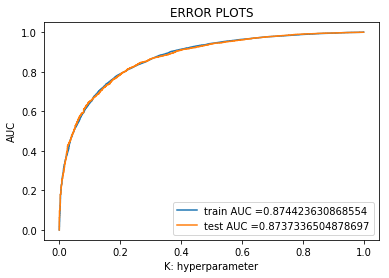

In [142]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

confusion_matrix for train_data


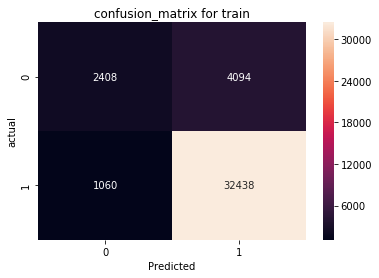

********************
confusion_matrix for test_data.


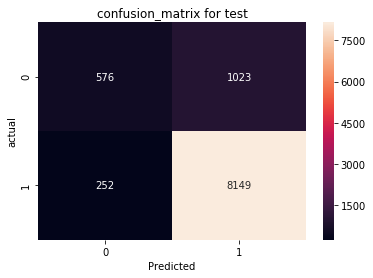

In [143]:
print("confusion_matrix for train_data")
conf_matrix = confusion_matrix(Y_train,optimal_model.predict(tfidf_sent_vectors_train))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("confusion_matrix for train")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()
print("*"*20)

print("confusion_matrix for test_data.")
conf_matrix = confusion_matrix(Y_test,optimal_model.predict(tfidf_sent_vectors_test))
class_label =[0,1]
df_conf_matrix = pd.DataFrame(conf_matrix,index=class_label,columns=class_label)
sns.heatmap(df_conf_matrix,annot=True,fmt='d')
plt.title("confusion_matrix for test")
plt.xlabel("Predicted")
plt.ylabel('actual')
plt.show()

In [144]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.36      0.47      1599
           1       0.89      0.97      0.93      8401

    accuracy                           0.87     10000
   macro avg       0.79      0.67      0.70     10000
weighted avg       0.86      0.87      0.86     10000



# [6] Conclusions

###### The following steps for L1 & L2 Regularization

1.) USing 100k dataset points from the total dataset.

2.) Splitting the dataset in to train_data,CV_data & test_data.

3.) Applying L1 & L2 Regularization both on BOW,TFIDF,AVG-W2V & TFIDF-W2V .

  3.1) Calculating the sparsity of weight vector using L1 Regularization on BOW

  3.2) similarly Performing the pertubation test on L2 Regulariztion on BOW

  3.3) finding Top 10 feature importance for both +ve & -ve class on BOW using L1 & L2   
      Regulariztion.

4.)Performing the Hyper Tuned parameter for both L1 & L2 Regularization

5.)Plot(train)  forthe ROC_AUC_curve for both the train & CV data.now,Applying the CV_score for the given selected range.

6.)plotting MSE(MissClassificationError) to get optimal_L1 & L2 from the cv_score.

7.) Taking an Optimal_model value so that it should not Overfit or Underfit.

8.)Plot(test) AUC_ROC_curve for train & test (tpr_fpr[TruePositiveRate & FalsePositiveRate]).
 
9.)Finding the error & accuracy for training & testing

10.)Plotting confusion matrix for both Train & Test data.

11.)from all the above process obtaining the average classification report.


##>>>>> from the step 4 to step 11 all these steps are repeated simalarly for (BOW,TFIDF,AVG-W2V & TFIDF-W2V)

In [146]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Regularization", "Hyperparameter", "AUC"]
 
comparison.add_row(["BOW",      'L1',         optimal_l1,     np.round(float(AUC1),4)])
comparison.add_row(["BOW",      'L2',         optimal_l2,    np.round(float(AUC2),4)])
comparison.add_row(["TFIDF",    'L1',        optimal_l3,           np.round(float(AUC3),4)])
comparison.add_row(["TFIDF",    'L2',       optimal_l4,        np.round(float(AUC4),4)])
comparison.add_row(["AVG W2V",   'L1',     optimal_l5,     np.round(float(AUC5),4)])
comparison.add_row(["AVG W2V",   'L2',      optimal_l6,     np.round(float(AUC6),4)])
comparison.add_row(["TFIDF W2V", 'L1', optimal_l7,  np.round(float(AUC7),4)])
comparison.add_row(["TFIDF W2V", 'L2', optimal_l8, np .round(float(AUC8),4)])
print(comparison)


+------------+----------------+---------------------+--------+
| Vectorizer | Regularization |    Hyperparameter   |  AUC   |
+------------+----------------+---------------------+--------+
|    BOW     |       L1       | 0.32999999999999996 | 0.9368 |
|    BOW     |       L2       | 0.10999999999999997 | 0.9392 |
|   TFIDF    |       L1       |  0.9899999999999999 | 0.9507 |
|   TFIDF    |       L2       |  0.9899999999999999 | 0.9556 |
|  AVG W2V   |       L1       |         0.29        | 0.895  |
|  AVG W2V   |       L2       | 0.12999999999999998 | 0.8952 |
| TFIDF W2V  |       L1       | 0.36999999999999994 | 0.8737 |
| TFIDF W2V  |       L2       |         0.15        | 0.8737 |
+------------+----------------+---------------------+--------+
